# Test

In [1]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import torchvision.transforms as transforms

pdb_folder = 'xyz_files'
img_folder = 'images_for_training'
os.makedirs(img_folder, exist_ok=True)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_dir, csv_file):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)

        self.transform = transforms.Compose([
            transforms.Pad((0, 0, 128-97, 128-97), fill=0),  # Pad adj (97x97) to 128x128
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.binary_transform = transforms.Compose([
            transforms.Pad((0, 0, 128-36, 128-97), fill=0),  # Pad binary (36x128) to 128x128
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        adj_img_name = row['adj_string']
        binary_img_name = row['binary_string']
        adj_img_path = os.path.join(self.image_dir, adj_img_name)
        binary_img_path = os.path.join(self.image_dir, binary_img_name)
        adj_image = Image.open(adj_img_path).convert('L')
        binary_image = Image.open(binary_img_path).convert('L')
        adj_image = self.transform(adj_image)
        binary_image = self.binary_transform(binary_image)
        image = torch.cat([adj_image, binary_image], dim=0)  # Combine into 2 channels
        label = row['polarizability']
        return image, torch.tensor(label, dtype=torch.float32)

# Diffusion Model
class ClassConditionedUnet(nn.Module):
    def __init__(self, class_emb_size=75):
        super().__init__()
        self.class_emb = nn.Linear(1, class_emb_size)
        self.model = UNet2DModel(
            sample_size=128,
            in_channels=2 + class_emb_size,  # 2 channels for input (adj + binary)
            out_channels=2,  # 2 channels for output (adj + binary)
            layers_per_block=2,
            block_out_channels=(64, 128, 256),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        embed = self.class_emb(class_labels.unsqueeze(-1))
        class_cond = embed.view(bs, embed.shape[1], 1, 1).expand(bs, embed.shape[1], w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t).sample

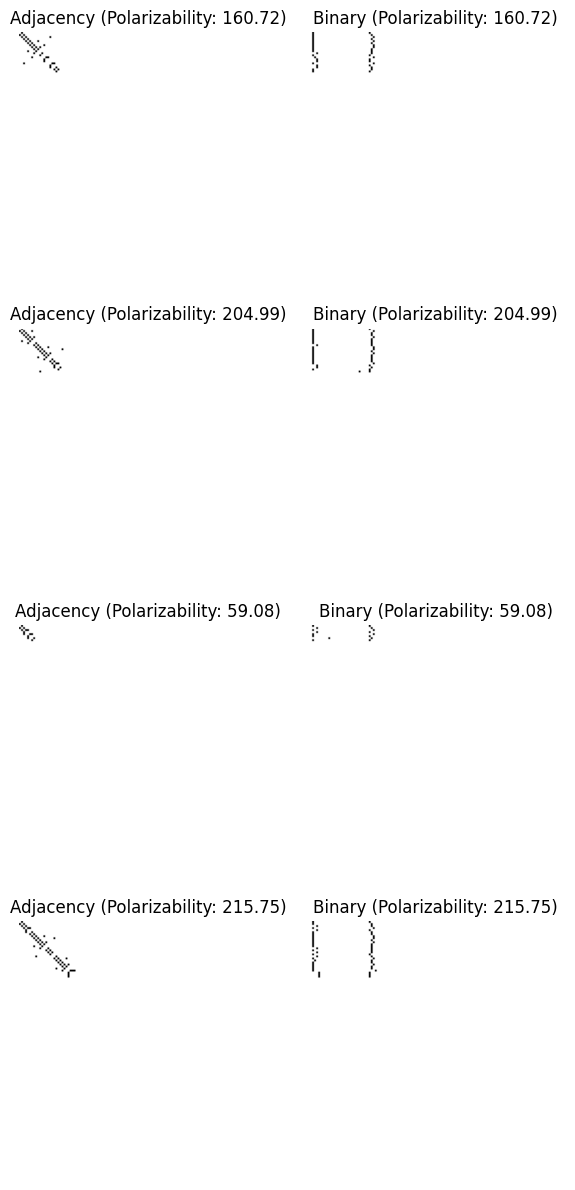

In [2]:
dataset = CustomDataset(img_folder, os.path.join(img_folder, 'polarizability.csv'))
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # Small batch for visualization
x, y = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 2, figsize=(6, 12))
for i in range(4):
    adj_img = x[i, 0].cpu().numpy().squeeze()  # Channel 0: Adjacency
    binary_img = x[i, 1].cpu().numpy().squeeze()  # Channel 1: Binary
    adj_img = (adj_img * 0.5 + 0.5).clip(0, 1)  # Denormalize from [-1, 1] to [0, 1]
    binary_img = (binary_img * 0.5 + 0.5).clip(0, 1)  # Denormalize
    axes[i, 0].imshow(adj_img, cmap='Greys')
    axes[i, 0].set_title(f'Adjacency (Polarizability: {y[i]:.2f})')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(binary_img, cmap='Greys')
    axes[i, 1].set_title(f'Binary (Polarizability: {y[i]:.2f})')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()
plt.close()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = CustomDataset(img_folder, os.path.join(img_folder, 'polarizability.csv'))
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
n_epochs = 15
losses = []
aux = 1e9

In [ ]:
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")
    if avg_loss < aux:
        torch.save(net, os.path.join(img_folder, 'diffusion_model2.pt'))
        aux = avg_loss
        
plt.plot(losses)
plt.close()

  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.158536


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.034928


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.026747


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.027120


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.015978


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.018580


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.014238


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.011284


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.008824


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.007886


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 100 loss values: 0.006476


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 100 loss values: 0.007338


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 100 loss values: 0.007063


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 100 loss values: 0.007139


  0%|          | 0/825 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 100 loss values: 0.014865


In [6]:
# Sampling one sample
x = torch.randn(1, 2, 256, 256).to(device)  # 2 channels
y = torch.tensor([184.754578883], dtype=torch.float32).to(device)
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample
# Split channels
adj_image = x[:, 0:1, :, :]  # Channel 0: Adjacency (1, 256, 256)
binary_image = x[:, 1:2, :, :]  # Channel 1: Binary (1, 256, 256)
# Save adjacency image

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(adj_image.detach().cpu().clip(-1, 1).squeeze(), cmap="Greys")
plt.axis('off')
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(binary_image.detach().cpu().clip(-1, 1).squeeze(), cmap="Greys")
plt.axis('off')
plt.show()